In [1]:
# How to go beyond 88% accuracy, simple MLP is not going to take us there. We need to exploit adjacency of pixels.
# Let us discuss convolutional networks

In [2]:
# https://jovian.ai/aakashns/05-cifar10-cnn
# https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
# https://distill.pub/2017/feature-visualization/


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import optim
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [294]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               ])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor(9)


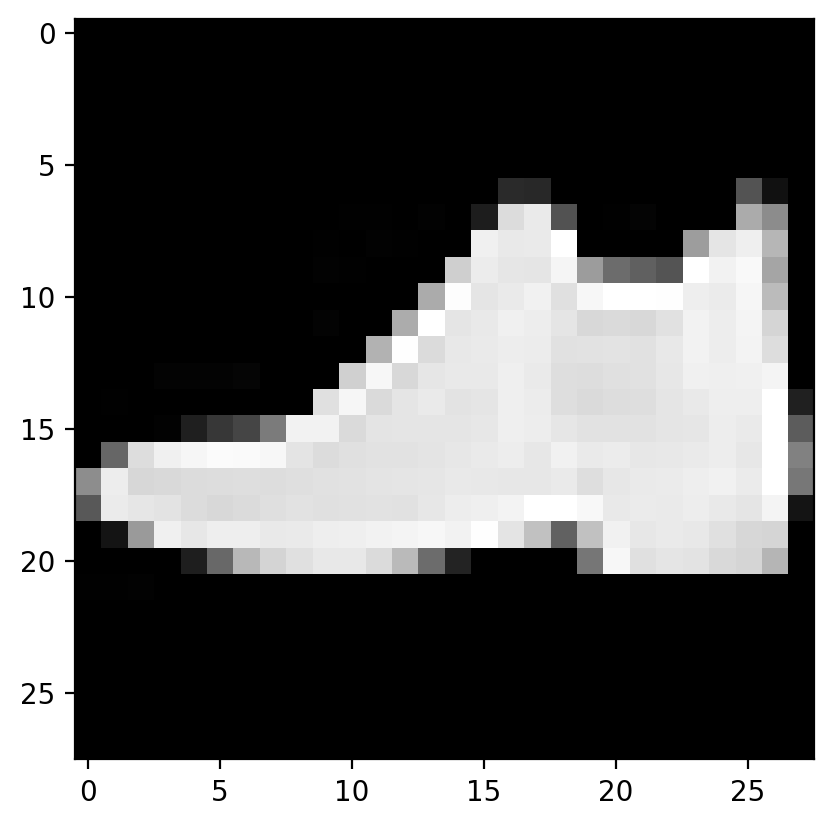

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)
print(labels[0])
plt.imshow(images[0].squeeze(), cmap='Greys_r');

In [24]:
# Explain what kernels are

## Defining the Model (Convolutional Neural Network)

In this lecture we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

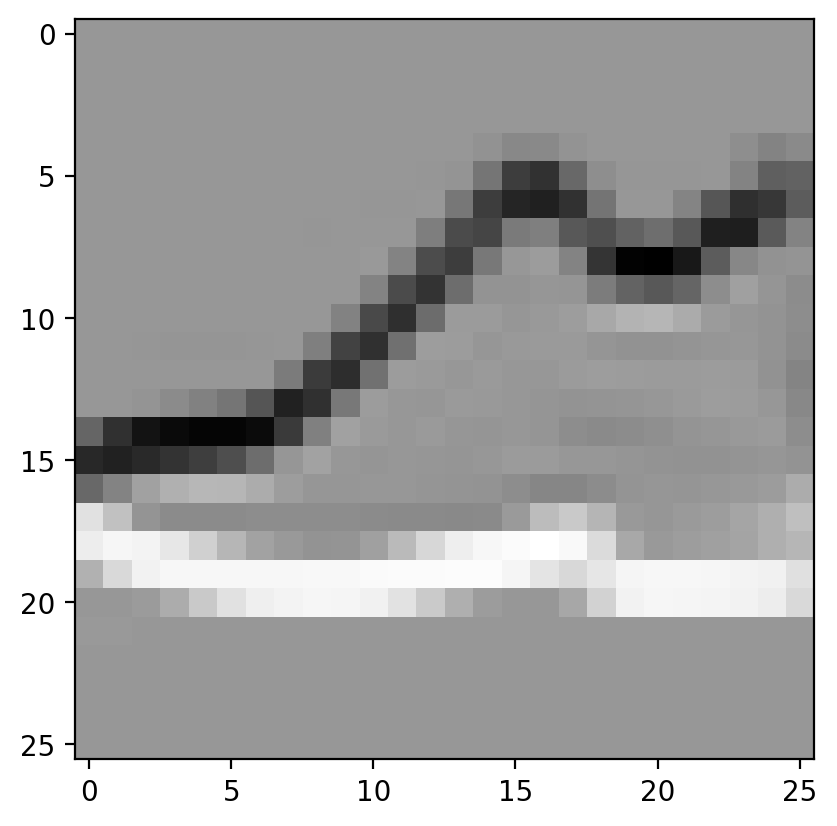

In [27]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

sobel_y = torch.tensor([[ 1.0, 2.0, 1.0], 
                   [ 0.0, 0.0, 0.0], 
                   [ -1.0, -2.0, -1.0]])

filtered_image = apply_kernel(images[0].squeeze(), sobel_y)
plt.imshow(filtered_image, cmap='Greys_r');

In [25]:
# Q. What is the kernel dimension for rgb image?
# Q. how many kernels do we need to get all sorts of edges?

In [26]:
# We would learn convolution kernels in convolution layers of the network.
# Has fewer connections compared to MLP. By taking a correct assumption, we have made it easier to train towards our goal.

In [37]:
# Q. what happens when we take a series of convolutions one after other? 
# explain stride and padding

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 
https://jovian.ai/aakashns/05-cifar10-cnn 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

According to Andrew Ng's Deep Learning lecture, max pooling works well but no one knows why. Quote -> "But I have to admit, I think the main reason people use max pooling is because it's been found in a lot of experiments to work well, ... I don't know of anyone fully knows if that is the real underlying reason."

In [71]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input channel, 8 kernels to be learned, 3x3 kernel size 
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1)  
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    # uncomment the print statement to see the shapes
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x= F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x= F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = x.view(x.shape[0], -1) # Flatten before feeding into MLP
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

model = Network()

In [75]:
epochs = 30
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # DO NOT Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        with torch.no_grad():
            for images, labels in testloader:
                output = model(images)
                loss = criterion(output, labels)
                
                tot_test_loss += loss.item()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()
                
        # Get mean loss to enable comparison between train and test sets
        train_loss = running_loss / len(trainloader)
        test_loss = tot_test_loss / len(testloader)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Training loss: 0.5888291731603873
Epoch: 1/30..  Training Loss: 0.589..  Test Loss: 0.437..  Test Accuracy: 0.842
Training loss: 0.38778099913332764
Epoch: 2/30..  Training Loss: 0.388..  Test Loss: 0.380..  Test Accuracy: 0.866
Training loss: 0.33870175302918276
Epoch: 3/30..  Training Loss: 0.339..  Test Loss: 0.364..  Test Accuracy: 0.865
Training loss: 0.30957188474725306
Epoch: 4/30..  Training Loss: 0.310..  Test Loss: 0.319..  Test Accuracy: 0.885
Training loss: 0.2840681817930645
Epoch: 5/30..  Training Loss: 0.284..  Test Loss: 0.300..  Test Accuracy: 0.893
Training loss: 0.26481246012550935
Epoch: 6/30..  Training Loss: 0.265..  Test Loss: 0.301..  Test Accuracy: 0.889
Training loss: 0.2493311932552725
Epoch: 7/30..  Training Loss: 0.249..  Test Loss: 0.278..  Test Accuracy: 0.900
Training loss: 0.23583727851033465
Epoch: 8/30..  Training Loss: 0.236..  Test Loss: 0.269..  Test Accuracy: 0.900
Training loss: 0.226094237431439
Epoch: 9/30..  Training Loss: 0.226..  Test Loss: 

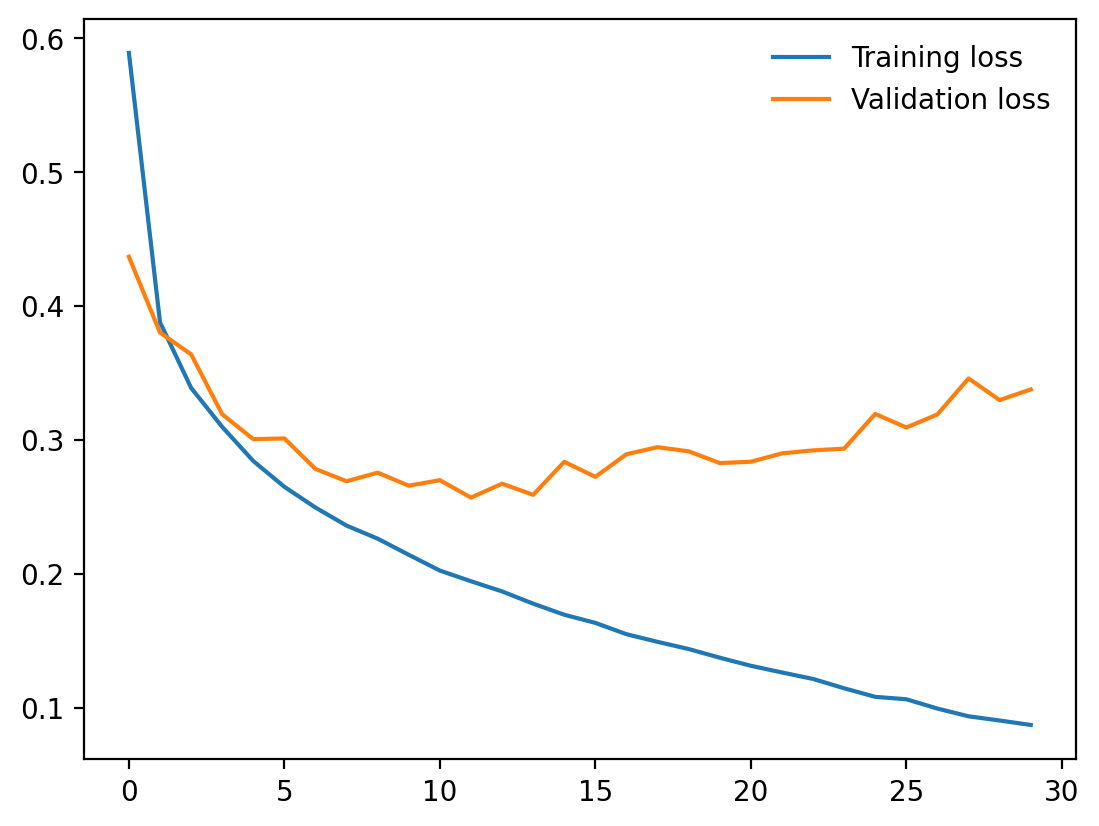

In [76]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [523]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input channel, 8 kernels to be learned, 3x3 kernel size 
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1)  
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)

    # uncomment the print statement to see the shapes
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = F.relu(self.conv1(x))
        x= F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x= F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1) # Flatten before feeding into MLP
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

model = Network()

In [522]:
epochs = 30
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.001) # discuss momentum
criterion = nn.NLLLoss()

train_losses, test_losses = [], []
model.train()

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # DO NOT Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                output = model(images)
                loss = criterion(output, labels)
                
                tot_test_loss += loss.item()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        model.train()
                
        # Get mean loss to enable comparison between train and test sets
        train_loss = running_loss / len(trainloader)
        test_loss = tot_test_loss / len(testloader)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

KeyboardInterrupt: 

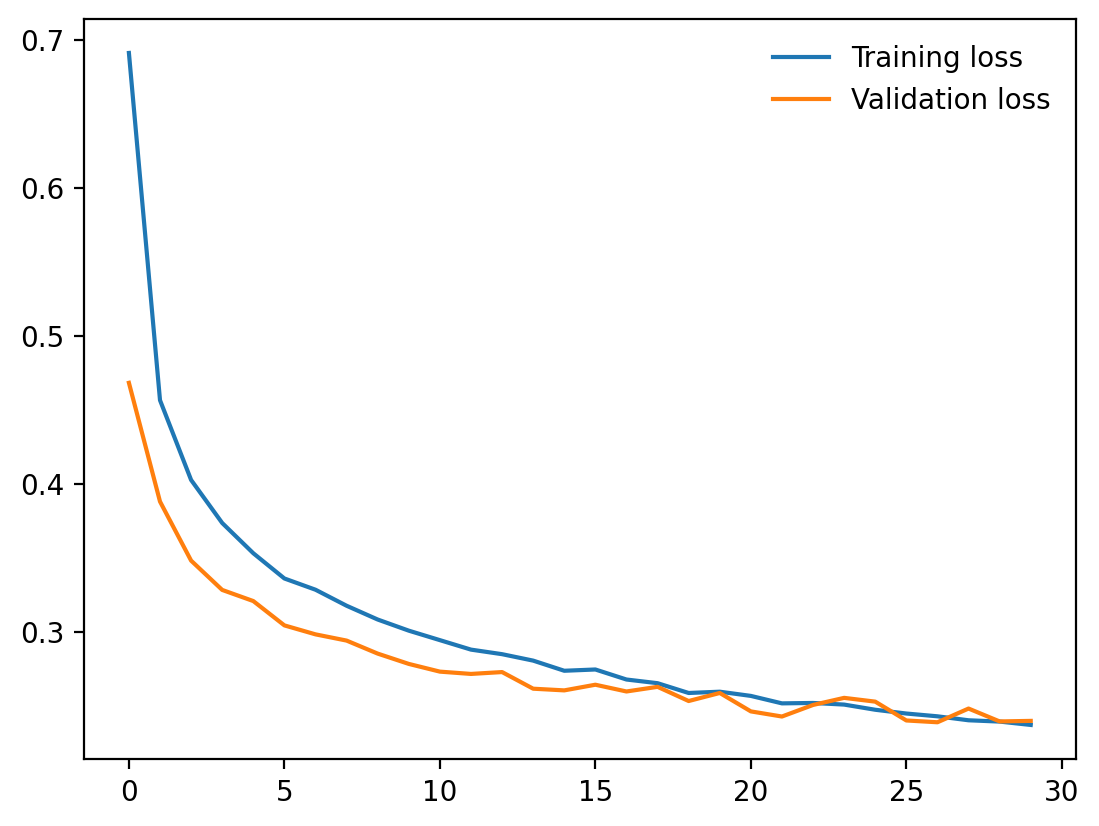

In [413]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [417]:
# Visualize what has been learned. 
model.conv1.weight[1][0]

tensor([[ 0.3390,  0.6583,  0.0885],
        [-0.3099, -0.2888,  0.4092],
        [-0.0024, -0.6377, -0.3277]], grad_fn=<SelectBackward0>)

torch.Size([64, 10])


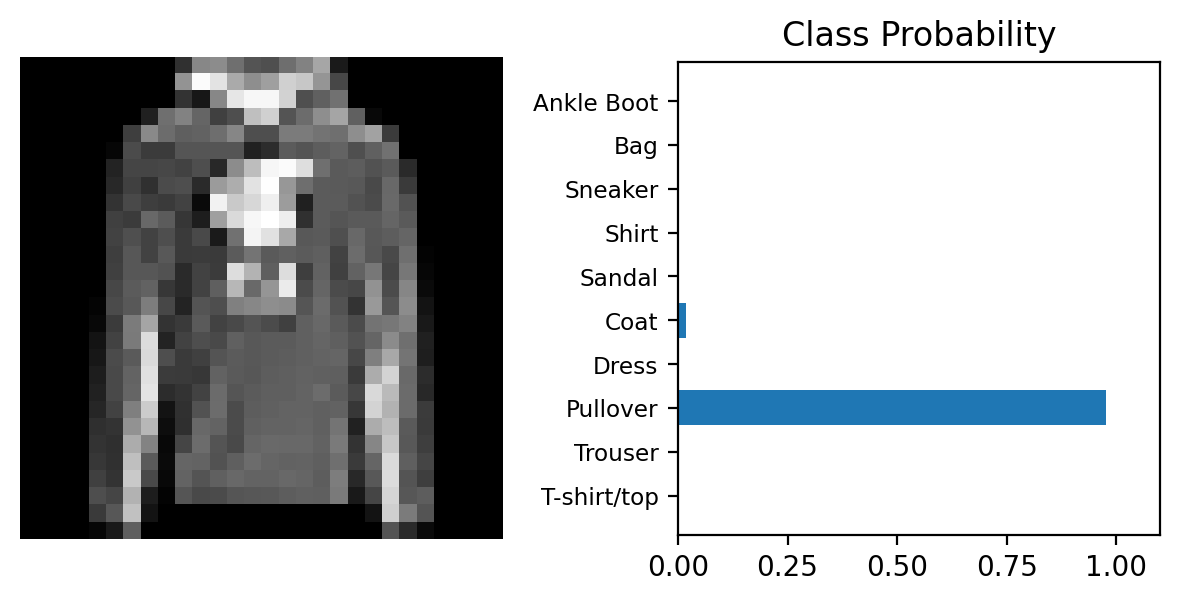

In [190]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Forward pass through the network
img_idx = 0
img = images[img_idx].view(1,1,28,28)
ps = torch.exp(model(images))
print(ps.shape)

view_classify(img.view(1, 28, 28), ps[0])

In [197]:
with torch.no_grad():
    idx = 0
    covOutput1 = model.conv1(img)
    print(model.conv1.weight[idx][0])

tensor([[-0.5883, -0.3082, -0.2825],
        [-0.3416, -0.0277,  0.5241],
        [ 0.2591,  0.2813,  0.0085]], requires_grad=True)


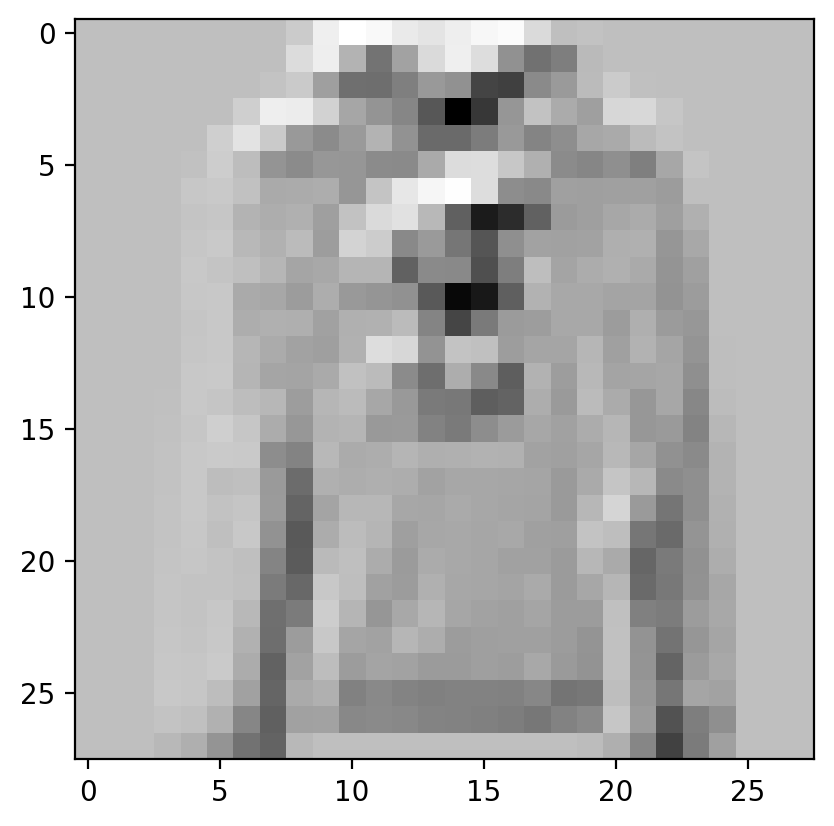

In [198]:
plt.imshow(covOutput1[0][idx].view(28,28), cmap='Greys_r')

(array([2.32998e+05, 5.68200e+03, 4.62600e+03, 4.84500e+03, 5.06500e+03,
        5.30100e+03, 2.62680e+04, 2.85540e+04, 4.98800e+03, 4.45700e+03,
        2.63330e+04, 5.12100e+03, 5.00800e+03, 3.84600e+03, 3.01000e+03,
        2.81300e+03, 2.80200e+03, 3.13100e+03, 3.40900e+03, 2.93900e+03,
        1.82200e+03, 1.44200e+03, 1.17800e+03, 1.11500e+03, 1.03400e+03,
        9.97000e+02, 1.00500e+03, 8.54000e+02, 7.88000e+02, 7.90000e+02,
        7.78000e+02, 7.76000e+02, 8.51000e+02, 8.31000e+02, 7.97000e+02,
        8.51000e+02, 8.57000e+02, 7.73000e+02, 7.47000e+02, 6.34000e+02,
        4.72000e+02, 3.61000e+02, 2.43000e+02, 1.42000e+02, 6.40000e+01,
        6.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.        , 0.02079938, 0.04159876, 0.06239814, 0.08319752,
        0.1039969 , 0.12479628, 0.14559566, 0.16639503, 0.18719441,
        0.20799379, 0.22879317, 0.24959255, 0.27039193, 0.29119131,
        0.31199069, 0.33279007, 0.35358945, 0.37438883, 0.395188

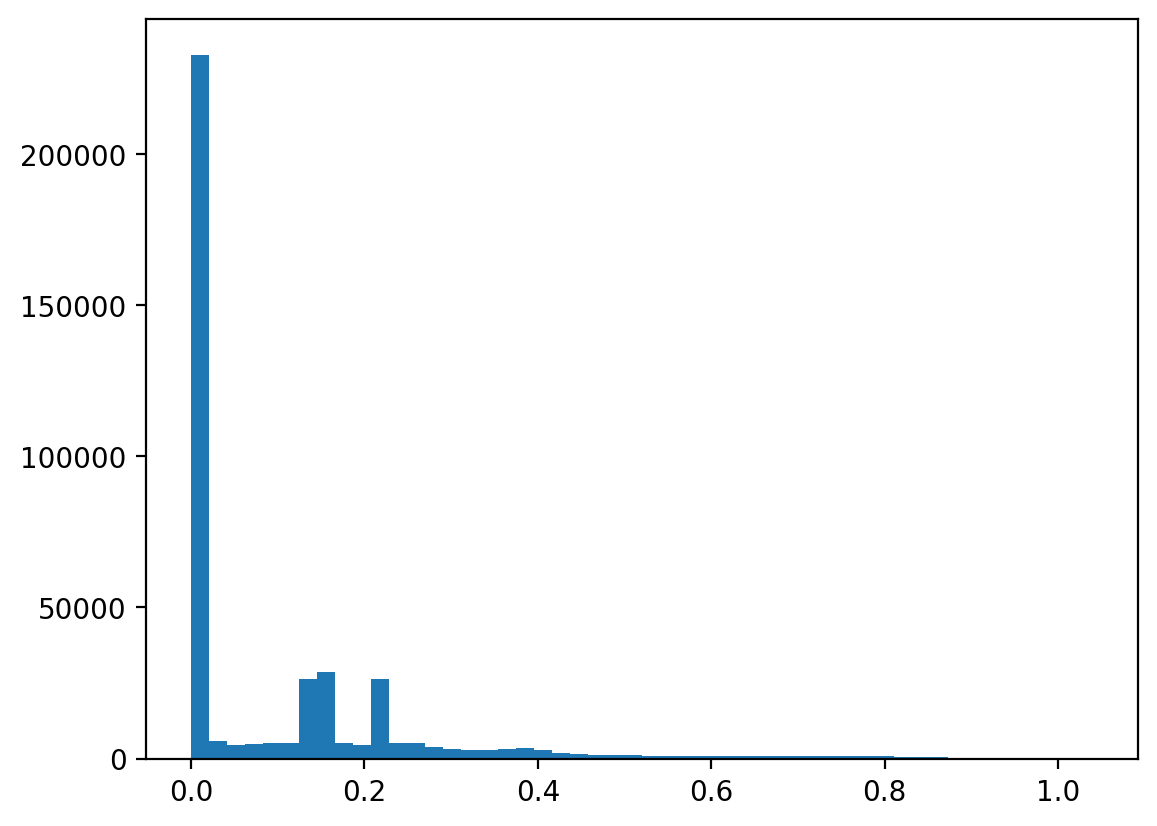

In [524]:
# let's debug the network
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
conv1_output = model.conv1(images)
activation1 = F.relu(conv1_output)
plt.hist(activation1.view(-1).tolist(), 50)

(array([2.0000e+00, 0.0000e+00, 3.0000e+00, 7.0000e+00, 1.6000e+01,
        2.8000e+01, 3.4000e+01, 5.9000e+01, 9.2000e+01, 1.4000e+02,
        1.5500e+02, 2.2100e+02, 2.5500e+02, 3.4200e+02, 4.6500e+02,
        6.3300e+02, 1.2500e+03, 2.0200e+03, 3.0210e+03, 4.0940e+03,
        4.2670e+03, 3.9920e+03, 3.6150e+03, 3.4710e+03, 3.2710e+03,
        3.0440e+03, 2.8470e+03, 2.8050e+03, 2.7330e+03, 2.6040e+03,
        2.6370e+03, 2.5490e+03, 2.9930e+03, 3.3150e+03, 4.7685e+04,
        3.8000e+03, 3.4220e+03, 2.5643e+04, 2.9640e+03, 2.7490e+03,
        2.4440e+03, 2.1480e+03, 2.1310e+03, 2.2040e+03, 2.4270e+03,
        2.4477e+04, 4.3310e+03, 2.6255e+04, 6.4100e+03, 6.4930e+03,
        8.7550e+03, 6.3850e+03, 4.7150e+03, 4.8600e+03, 5.0070e+03,
        5.2800e+03, 5.8980e+03, 4.9045e+04, 4.9890e+03, 4.5360e+03,
        5.5460e+03, 2.5890e+04, 5.0410e+03, 4.0960e+03, 3.0640e+03,
        2.8590e+03, 2.8200e+03, 3.0990e+03, 3.3730e+03, 3.0750e+03,
        1.9350e+03, 1.4630e+03, 1.2130e+03, 1.13

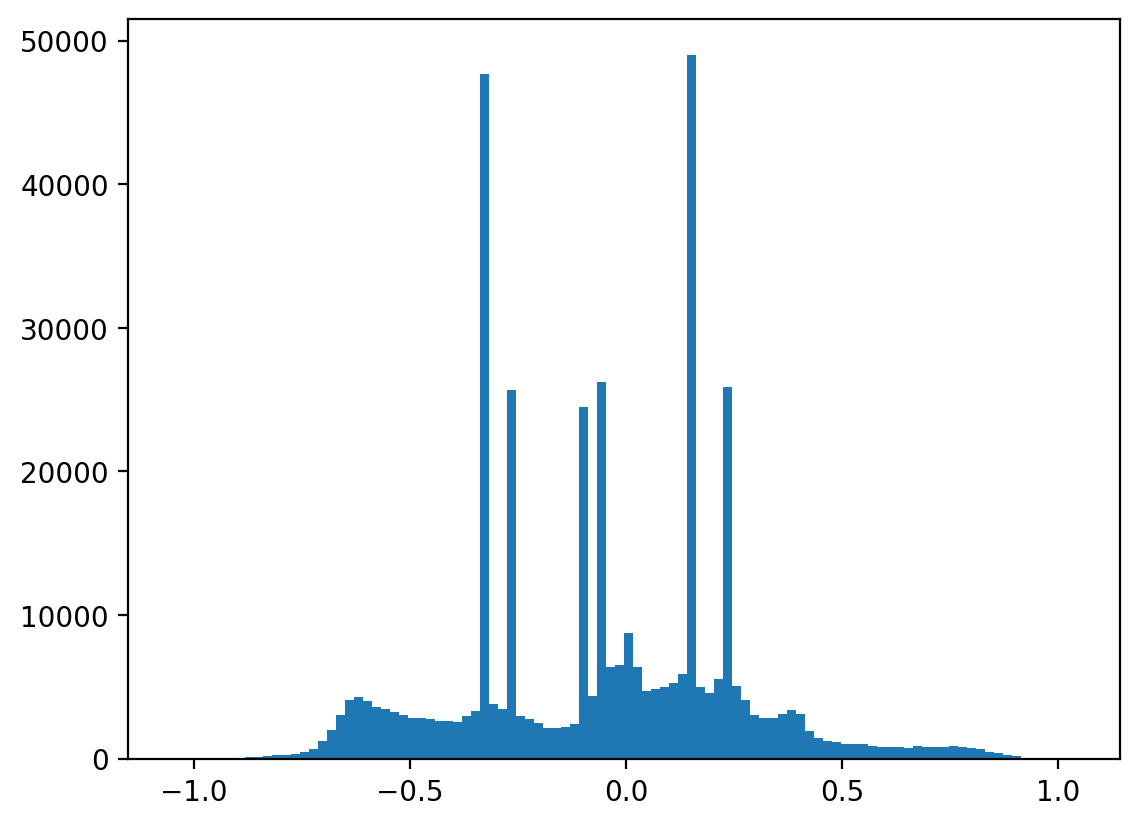

In [525]:
plt.hist(conv1_output.view(-1).tolist(), 100)

torch.Size([64, 8, 28, 28])


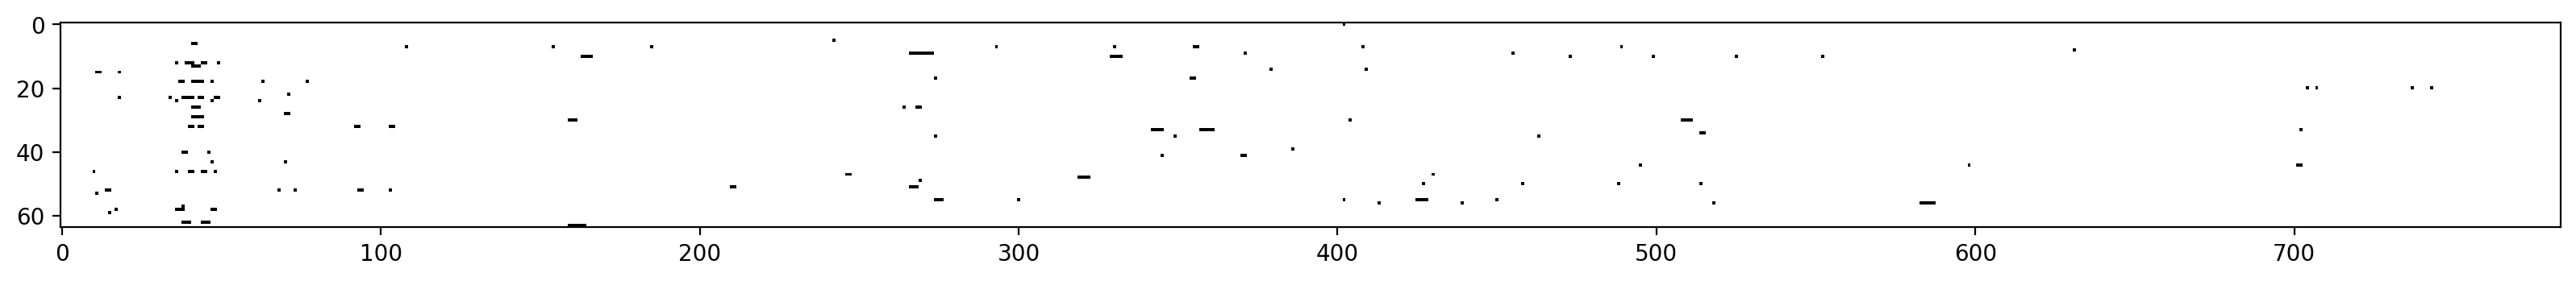

In [429]:
print(activation1.shape)
plt.figure(figsize=(20,10))
kernel_num = 6 # vary this to see if there are dead neurons
plt.imshow((activation1[:,kernel_num,:,:] == 0).view(activation1[:,kernel_num,:,:].shape[0], - 1), cmap="gray", interpolation="nearest")

(array([2.0000e+00, 4.0000e+00, 1.3000e+01, 1.7000e+01, 4.3000e+01,
        4.1000e+01, 6.5000e+01, 8.5000e+01, 9.3000e+01, 1.3200e+02,
        1.4500e+02, 2.0300e+02, 2.2000e+02, 2.9600e+02, 3.8200e+02,
        5.3800e+02, 7.7000e+02, 1.1410e+03, 2.2711e+04, 2.5630e+03,
        1.6450e+03, 1.9370e+03, 2.1110e+03, 2.0870e+03, 1.6870e+03,
        1.6010e+03, 1.7540e+03, 2.0340e+03, 2.4650e+03, 1.1200e+03,
        5.3100e+02, 3.6900e+02, 2.7800e+02, 2.2600e+02, 1.9300e+02,
        1.5900e+02, 1.4200e+02, 7.1000e+01, 7.4000e+01, 4.0000e+01,
        4.6000e+01, 4.7000e+01, 3.4000e+01, 2.3000e+01, 1.5000e+01,
        8.0000e+00, 1.0000e+01, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.56646419, -0.55209849, -0.5377328 , -0.52336711, -0.50900141,
        -0.49463572, -0.48027003, -0.46590433, -0.45153864, -0.43717295,
        -0.42280725, -0.40844156, -0.39407587, -0.37971017, -0.36534448,
        -0.35097879, -0.33661309, -0.3222474 , -0.30788171, -0.29351601,
        -0.27915032, -0.26

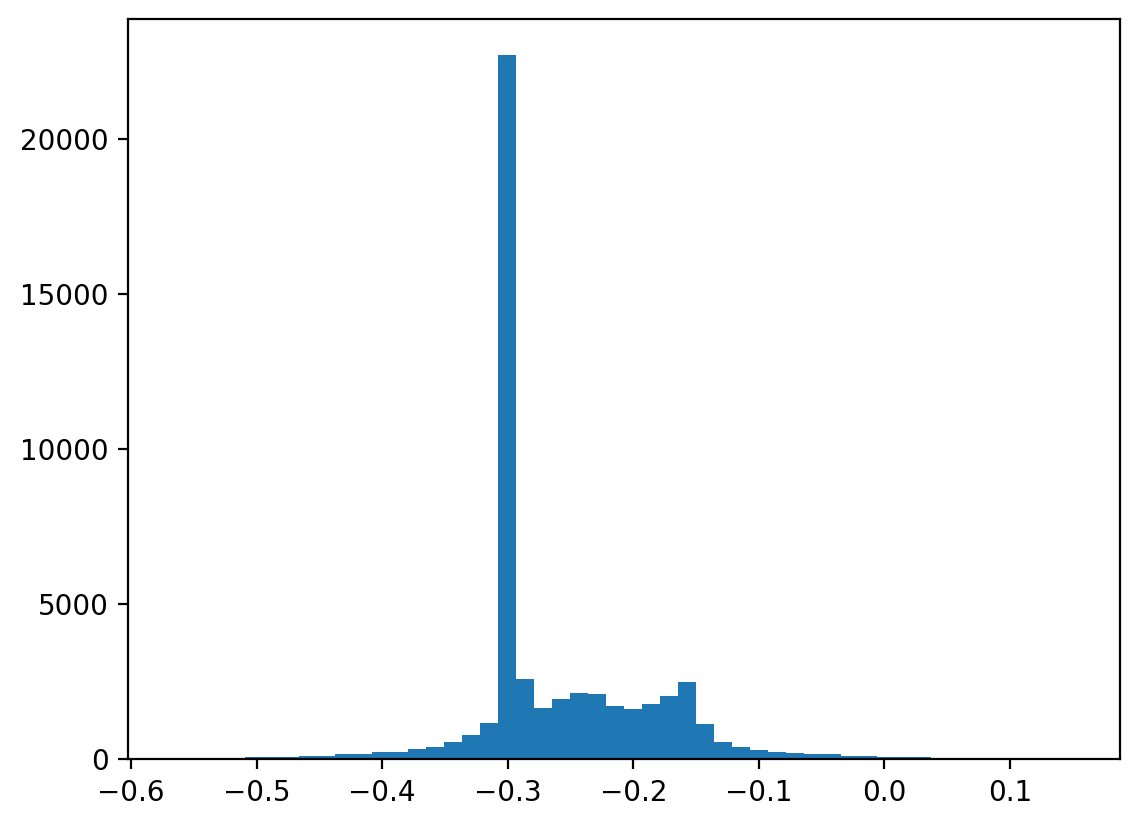

In [430]:
plt.hist(conv1_output[:,kernel_num,:,:].reshape(-1).tolist(), 50)

In [533]:
# let us do one complete pass
optimizer.zero_grad()
conv1_output = model.conv1(images)
activation1 = F.relu(conv1_output)
x = activation1
x= F.max_pool2d(x, 2, 2)
x = model.dropout(x)
x = F.relu(model.conv2(x))
x= F.max_pool2d(x, 2, 2)
x = model.dropout(x)
x = x.view(x.shape[0], -1) # Flatten before feeding into MLP
x = F.relu(model.fc1(x))
x = model.dropout(x)
x = model.fc2(x)
x = F.log_softmax(x, dim=1)
loss = criterion(x, labels)
loss.backward()

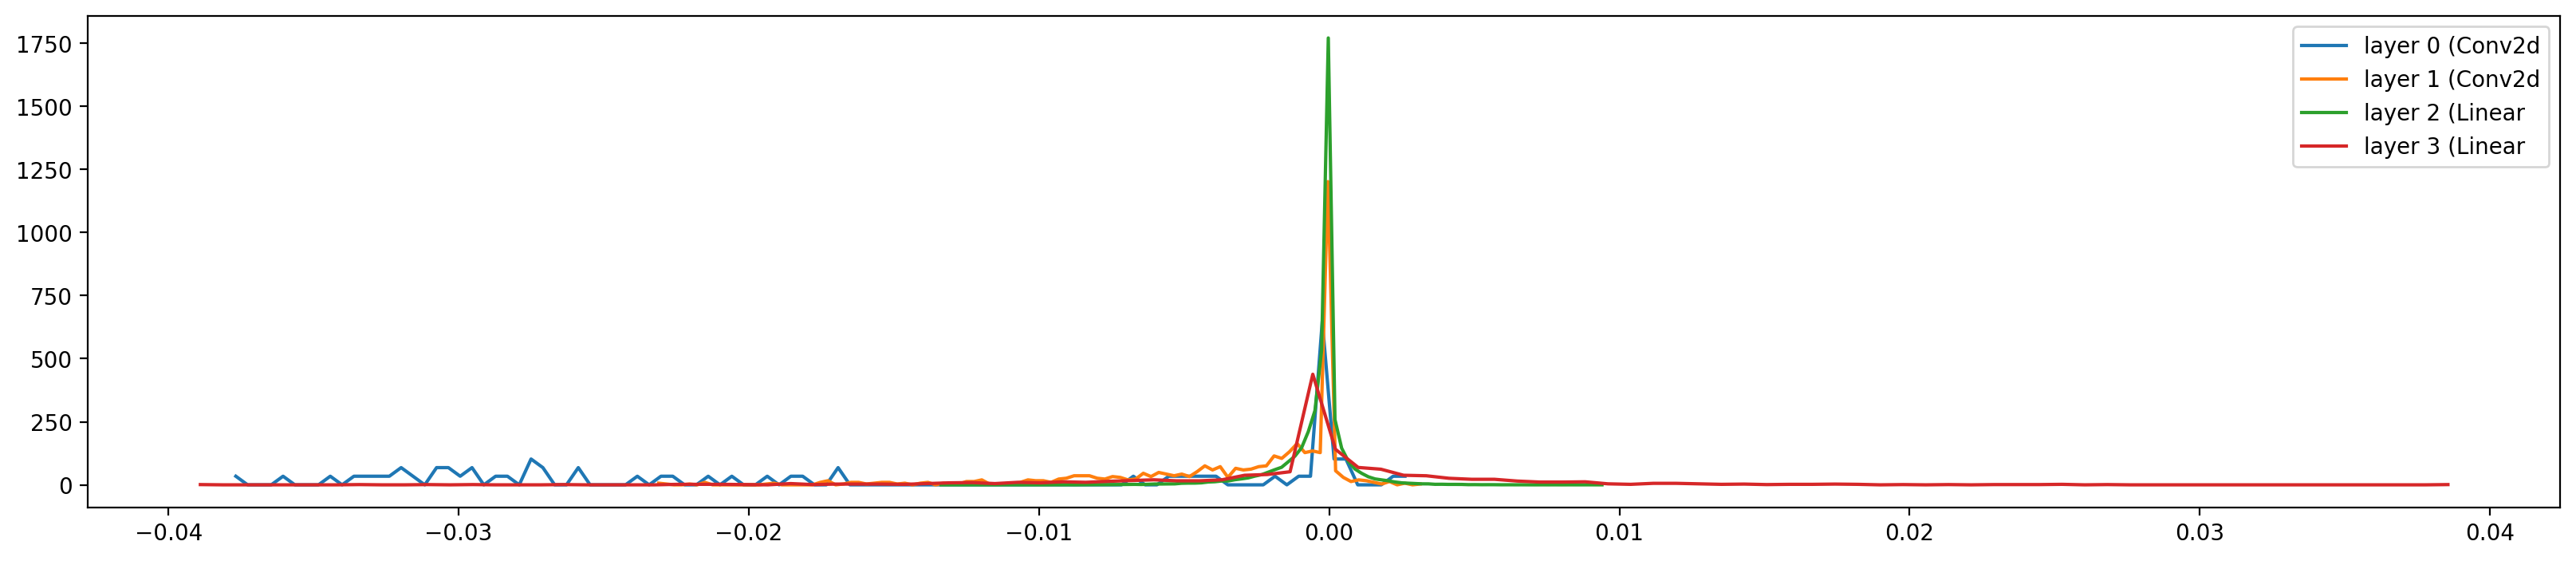

In [534]:
layers = [model.conv1, model.conv2, model.fc1, model.fc2]
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    legends.append(f'layer {i} ({layer.__class__.__name__}')
    y, x = torch.histogram((layer.weight.grad).view(-1).detach(), density=True) # change between weight.grad and weight
    plt.plot(x[:-1].cpu(), y.cpu())
plt.legend(legends)

In [532]:
optimizer.step() # show update to weights and gradients

In [463]:
# some further updates - see any pattern?
for images, labels in trainloader:
    optimizer.zero_grad()
            
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

In [270]:
# We do not want dead neurons that do not learn and thus don't contribute
# For relu, we want the neurons to fire sometimes and sometimes not, neither always , nor never 
# we get that behavior if the input is kind of centered around 0. Batch normalization does this.
# https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

# Discuss -  how does batch norm work for train and testing? mean and variance calculation
# https://towardsdatascience.com/batch-norm-explained-visually-why-does-it-work-90b98bcc58a0

<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*VsN_9_AN2ji8hCZYSTTV0w.png"/>

In [279]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input channel, 8 kernels to be learned, 3x3 kernel size 
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1)  
        self.batchNorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(784, 128)
        self.batchNorm3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    # uncomment the print statement to see the shapes
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = F.relu(self.batchNorm1(self.conv1(x)))
        x= F.max_pool2d(x, 2, 2)
        x = F.relu(self.batchNorm2(self.conv2(x)))
        x= F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0], -1) # Flatten before feeding into MLP
        x = F.relu(self.batchNorm3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

model = Network()

In [281]:
epochs = 15
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

train_losses, test_losses = [], []
model.train()

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # DO NOT Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                output = model(images)
                loss = criterion(output, labels)
                
                tot_test_loss += loss.item()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        model.train()
                
        # Get mean loss to enable comparison between train and test sets
        train_loss = running_loss / len(trainloader)
        test_loss = tot_test_loss / len(testloader)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Training loss: 0.45232768250363214
Epoch: 1/15..  Training Loss: 0.452..  Test Loss: 0.315..  Test Accuracy: 0.886
Training loss: 0.3169937084939307
Epoch: 2/15..  Training Loss: 0.317..  Test Loss: 0.284..  Test Accuracy: 0.897
Training loss: 0.28212455073907683
Epoch: 3/15..  Training Loss: 0.282..  Test Loss: 0.277..  Test Accuracy: 0.899
Training loss: 0.26070918562188583
Epoch: 4/15..  Training Loss: 0.261..  Test Loss: 0.253..  Test Accuracy: 0.909
Training loss: 0.24638085645923355
Epoch: 5/15..  Training Loss: 0.246..  Test Loss: 0.271..  Test Accuracy: 0.898
Training loss: 0.2351911515235774
Epoch: 6/15..  Training Loss: 0.235..  Test Loss: 0.242..  Test Accuracy: 0.911
Training loss: 0.22598424748475873
Epoch: 7/15..  Training Loss: 0.226..  Test Loss: 0.283..  Test Accuracy: 0.898
Training loss: 0.21675776489682672
Epoch: 8/15..  Training Loss: 0.217..  Test Loss: 0.244..  Test Accuracy: 0.910
Training loss: 0.2082804875221969
Epoch: 9/15..  Training Loss: 0.208..  Test Loss

In [277]:
# We are able to reach similar accuracy much more quickly, basically attaining network's full potential by efficiently using more of 
# the brain power available. But not improving further, time to increase brain power.

In [493]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.batchNorm3 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.batchNorm4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.batchNorm3(self.fc1(out)))
        out = self.drop(out)
        out = F.relu(self.batchNorm4(self.fc2(out)))
        out = self.drop(out)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [387]:
epochs = 60
gpu = torch.device("mps")
model = Network().to(gpu)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

train_losses, test_losses = [], []
model.train()

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(gpu), labels.to(gpu)
        # DO NOT Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images, labels = images.to(gpu), labels.to(gpu)
                output = model(images)
                loss = criterion(output, labels)
                
                tot_test_loss += loss.item()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        model.train()
                
        # Get mean loss to enable comparison between train and test sets
        train_loss = running_loss / len(trainloader)
        test_loss = tot_test_loss / len(testloader)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Training loss: 0.5119965897440147
Epoch: 1/60..  Training Loss: 0.512..  Test Loss: 0.343..  Test Accuracy: 0.873
Training loss: 0.37031192958418496
Epoch: 2/60..  Training Loss: 0.370..  Test Loss: 0.291..  Test Accuracy: 0.893
Training loss: 0.3370622505527188
Epoch: 3/60..  Training Loss: 0.337..  Test Loss: 0.292..  Test Accuracy: 0.892
Training loss: 0.31483527381759463
Epoch: 4/60..  Training Loss: 0.315..  Test Loss: 0.263..  Test Accuracy: 0.900
Training loss: 0.29786988164284334
Epoch: 5/60..  Training Loss: 0.298..  Test Loss: 0.259..  Test Accuracy: 0.904
Training loss: 0.2873394211519883
Epoch: 6/60..  Training Loss: 0.287..  Test Loss: 0.271..  Test Accuracy: 0.900
Training loss: 0.2765505289885281
Epoch: 7/60..  Training Loss: 0.277..  Test Loss: 0.252..  Test Accuracy: 0.904
Training loss: 0.2675381938515823
Epoch: 8/60..  Training Loss: 0.268..  Test Loss: 0.255..  Test Accuracy: 0.904
Training loss: 0.26222028648421203
Epoch: 9/60..  Training Loss: 0.262..  Test Loss: 

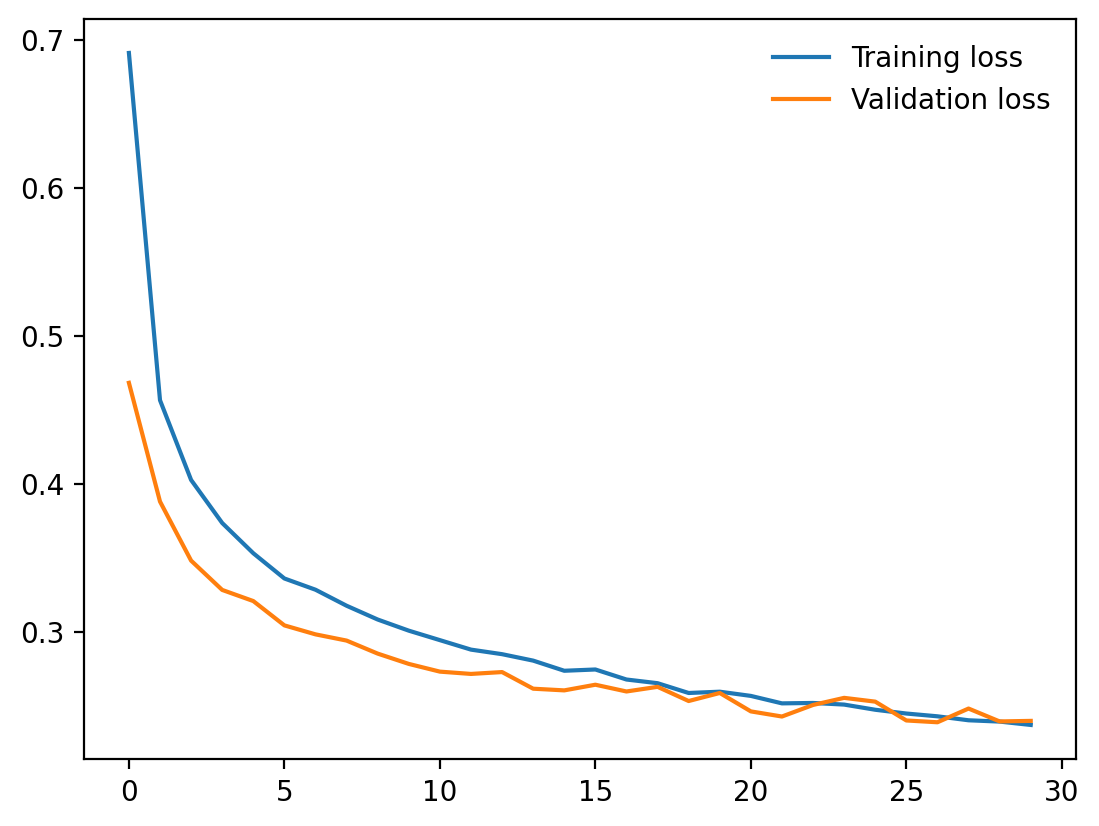

In [468]:
# What is an acceptable accuracy? Discuss benchmarking against human evaluation.
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# https://forums.fast.ai/t/a-challenge-for-you-all/102656?replies_to_post_number=3
# When do we stop optimizing further and deploy?

In [497]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
dataiter = iter(trainloader)

In [528]:
layers = [model.layer1[0], model.layer2[0], model.layer3[0], model.fc1, model.fc2, model.fc3]
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    legends.append(f'layer {i} ({layer.__class__.__name__}')
    y, x = torch.histogram((layer.weight.grad).view(-1).detach(), density=True)
    plt.plot(x[:-1].cpu(), y.cpu())
plt.legend(legends)

AttributeError: 'Network' object has no attribute 'layer1'

In [512]:

optimizer.zero_grad()
    
output = model(images)
loss = criterion(output, labels)
loss.backward()
optimizer.step()

In [514]:
for images, labels in trainloader:
    optimizer.zero_grad()
            
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

In [516]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4